[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)

In [1]:
import os, sys

os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from functools import partial
import numpy as np, scipy
from scipy.optimize import elementwise
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM_examples.Grabowski_and_Pawlowska_2023.settings import DRY_SPECTRA
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.physics.dimensional_analysis import DimensionalAnalysis

In [3]:
n_sd=2**6 # TEMP 2**10
commons = {
    'kappa': 1.28,
    'init_temperature_K': 300,
    'init_dry_pressure_Pa': 100000,
    'total_water_mixing_ratio': 20/1000,
    't_max_s': 300, # TEMP!
}

dry_spectra = {
    aerosol: ConstantMultiplicity(DRY_SPECTRA[aerosol][commons['kappa']]).sample_deterministic(n_sd)
    for aerosol in DRY_SPECTRA
}

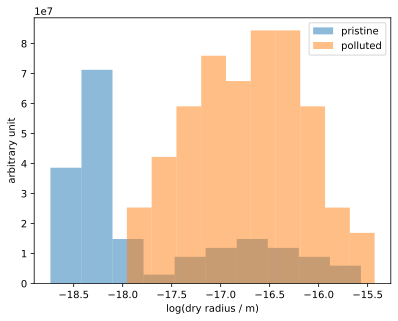

In [4]:
for aerosol, data in dry_spectra.items():
    pyplot.hist(np.log(data[0]), weights=data[1], density=False, label=aerosol, alpha=.5)
pyplot.gca().set(ylabel="arbitrary unit", xlabel="log(dry radius / m)")
pyplot.legend()
show_plot()


In [5]:
from collections import namedtuple
make_namedtuple = lambda name, items: namedtuple(name, items.keys())(*items.values())

ix = make_namedtuple("I", {
    "ln_rw": slice(0, n_sd),
    "pd": n_sd,
    "T": n_sd + 1,
    "size": n_sd + 2
})
print(ix)

I(ln_rw=slice(0, 64, None), pd=64, T=65, size=66)


In [6]:
formulae = make_namedtuple("F", {
    # eq. (1) in the NPG paper
    "dr_dt": lambda c, rw, rho_v, rho_o: c.D_eff / c.rho_w * (rho_v - rho_o) / rw,
    # eq. (4) in the NPG paper
    "RH_eq": lambda c, rw, rd: 1 + c.A / rw - c.κ * (rd / rw)**3,
    # eq. (13) in the NPG paper
    "dpd_dt": lambda c, rhod, w: -rhod * c.g * w,
    "dT_dt": lambda c, dpd_dt, dqv_dt, rhod: (dpd_dt / rhod - dqv_dt * c.l_v) / c.cp_d,
    # Bolton 1980 saturation vapour pressure formula (https://doi.org/10.1175/1520-0493(1980)108%3C1046:TCOEPT%3E2.0.CO;2)
    "pvs": lambda c, T: c.B80_G0 * np.exp((c.B80_G1 * (T - c.T0)) / ((T - c.T0) + c.B80_G2)),
    # trivia
    "rhod": lambda c, pd, T: pd / c.R_d / T,
    "rhov": lambda c, pv, T: pv / c.R_v / T,
    "RH": lambda c, rw3, rho_vs, rhod: rhod * (c.qt - np.dot(rw3, c.xi) / c.m_d * 4/3 * np.pi * c.rho_w) / rho_vs,
    "dqv_dt": lambda c, rw, drw_dt: -4 * np.pi * np.dot(c.xi * rw**2, drw_dt) / c.m_d * c.rho_w,
    "w": lambda c, t: 1,  # TODO !
})

In [7]:
from PySDM import physics
import mendeleev

def constants(*, kappa, dry_spectrum, total_water_mixing_ratio, t_max_s):        
    r_dry = dry_spectrum[0]
    multiplicities = dry_spectrum[1]
    
    SI = physics.si

    M_a = (
        0.78 * 2 * mendeleev.N.atomic_weight * SI.g / SI.mole + 
        0.21 * 2 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        0.01 * 1 * mendeleev.Ar.atomic_weight * SI.g / SI.mole
    )
    M_v = (
        1 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        2 * mendeleev.H.atomic_weight * SI.g / SI.mole
    )
    R_str = scipy.constants.R * SI.J / SI.K / SI.mole
    
    constants = make_namedtuple("C", {
        "R_d": R_str / M_a,
        "R_v": R_str / M_v,
        "cp_d": 1000 * SI.J / SI.kg / SI.K,
        "l_v": 45000 * SI.joule / SI.mol / M_v,
        "g": scipy.constants.g * SI.m / SI.s**2,
        "A": 1e-3 * SI.um,
        "rho_w": 1 * SI.kg / SI.litre,
        "D_eff": 2.3e-5 * SI.metre**2 / SI.s,
        "T0": scipy.constants.zero_Celsius * SI.K,

        "B80_G0": 6.112 * SI.hPa,
        "B80_G1": 17.67 * SI.dimensionless,
        "B80_G2": 243.5 * SI.K,
        
        "κ": kappa,
        "r_d": r_dry * SI.m,
        "xi": multiplicities,
        "m_d": 1 * SI.kg,
        "qt": total_water_mixing_ratio,
        "t_max": t_max_s * SI.s,
    })
    return constants, SI

def initial_condition(SI, r_dry, constants, init_dry_pressure_Pa, init_temperature_K,):
    RH = formulae.RH(constants,
                 rw3=np.zeros_like(r_dry),
                 rho_vs=formulae.rhov(constants, pv=formulae.pvs(constants, init_temperature_K), T=init_temperature_K),
                 rhod=formulae.rhod(constants, pd=init_dry_pressure_Pa, T=init_temperature_K)
                )
    result = elementwise.find_root(lambda r_wet, r_dry: RH - formulae.RH_eq(constants, r_wet, r_dry), (r_dry, 1e3 * r_dry), args=(r_dry,))
    assert all(result.success)

    y0 = [0] * ix.size
    y0[ix.pd] = init_dry_pressure_Pa * SI.Pa
    y0[ix.T] = init_temperature_K * SI.K
    y0[ix.ln_rw] = np.log(result.x)
    
    return y0

In [8]:
import numba
jit_compile = numba.jit(error_model='numpy', fastmath=True)

In [9]:
jf = make_namedtuple("J", {k: jit_compile(v) for k, v in formulae._asdict().items()})

@jit_compile
def ode_rhs(t, y, c):
    rhod = jf.rhod(c, pd=y[ix.pd], T=y[ix.T])
    rho_vs = jf.rhov(c, pv=jf.pvs(c, y[ix.T]), T=y[ix.T])
    rw = np.exp(y[ix.ln_rw])
    RH = jf.RH(c, rw3=rw**3, rho_vs=rho_vs, rhod=rhod)
    RH_eq = jf.RH_eq(c, rw=rw, rd=c.r_d)
    
    dy_dt = np.empty_like(y)
    dy_dt[ix.pd] = jf.dpd_dt(c, rhod=rhod, w=jf.w(c, t))
    dy_dt[ix.ln_rw] = jf.dr_dt(c, rw=rw, rho_v=RH * rho_vs, rho_o=RH_eq * rho_vs) / rw
    dy_dt[ix.T] = jf.dT_dt(c, dpd_dt=dy_dt[ix.pd], dqv_dt=jf.dqv_dt(c, rw=rw, drw_dt=dy_dt[ix.ln_rw] * rw), rhod=rhod)
    return dy_dt

In [10]:
@jit_compile
def solve(y, nt, dt, fun, args):
    for step in range(1, nt + 1):
        y[:, step] = y[:, step - 1] + dt * fun(step * dt, y[:, step - 1], *args)
    return y

def explicit_euler(*, fun, t_span, y0, min_step, max_step, args):
    dt = min_step
    nt = int((t_span[1] - t_span[0]) / dt)
    y = np.empty(shape=(len(y0), nt + 1))
    y[:, 0] = y0
    
    return make_namedtuple("Solution", {
        'success': True,
        'message': '',
        'y': solve(y, nt, dt, fun, args),
        't': np.linspace(t_span[0], t_span[1], nt+1, endpoint=True),
    })

In [13]:
 solutions = {}
 for aerosol, dry_spectrum in dry_spectra.items():
    c, SI = constants(dry_spectrum=dry_spectrum, kappa=commons['kappa'], total_water_mixing_ratio=commons['total_water_mixing_ratio'], t_max_s=commons['t_max_s'])
    y0 = initial_condition(SI, dry_spectrum[0], constants=c, init_dry_pressure_Pa=commons['init_dry_pressure_Pa'], init_temperature_K=commons['init_temperature_K'])
    for key, solver in {
        # f"{aerosol}-EULER" : partial(explicit_euler, min_step=.5 * SI.s),
        f"{aerosol}-LSODA" : partial(scipy.integrate.solve_ivp, method='LSODA'),
    }.items():
        solution = solver(
            fun=ode_rhs, 
            t_span=(0, c.t_max),
            y0=y0,
            max_step=.5 * SI.s,
            args=(c,),
        )
        assert solution.success, solution.message
        solutions[key] = solution

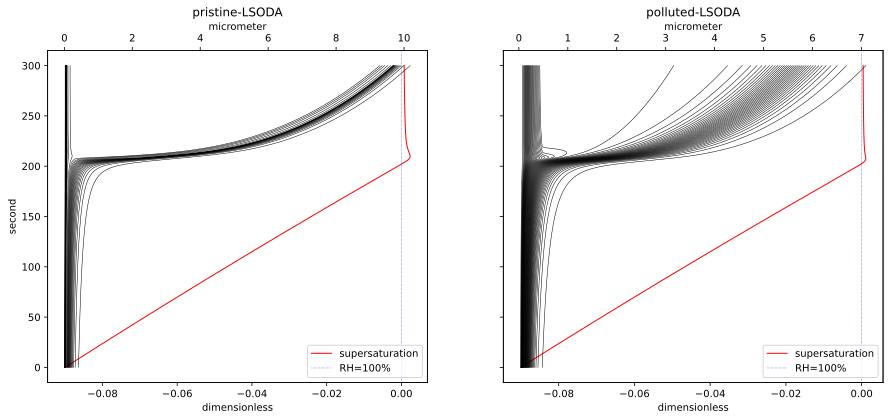

In [14]:
fig, axs = pyplot.subplot_mosaic([solutions.keys()], sharey=True, figsize=(15, 6))
for aerosol, solution in solutions.items():
    with DimensionalAnalysis():
        c, SI = constants(dry_spectrum=dry_spectra[aerosol[:aerosol.find('-')]], kappa=commons['kappa'], total_water_mixing_ratio=commons['total_water_mixing_ratio'], t_max_s=commons['t_max_s'])
        SI.setup_matplotlib()
    
        t = solution.t * SI.s
        pd = solution.y[ix.pd] * SI.Pa
        T = solution.y[ix.T] * SI.K
        rw = np.exp(solution.y[ix.ln_rw]) * SI.m
        RH = formulae.RH(c,
                         rw3=rw.T**3,
                         rho_vs=formulae.rhov(c, pv=formulae.pvs(c, T), T=T),
                         rhod=formulae.rhod(c, pd=pd, T=T)
                        )
        axs[aerosol].plot(RH - 1, t, label="supersaturation", color='red', linewidth=1)
        axs[aerosol].axvline(0, label="RH=100%", linestyle=':', color='blue', linewidth=.5)
        axs[aerosol].legend(loc='lower right')
        axs[aerosol].set_title(aerosol)
        twin = axs[aerosol].twiny()
        for i in range(ix.ln_rw.start, ix.ln_rw.stop):
            twin.plot(rw[i], t, color='k', linewidth=.5)
        twin.xaxis.set_units(SI.um)
        
show_plot()

TODO:
- sinusoidal velocity (+analytic integral for plotting)
- constants from PySDM (?)
- plots for different velocities
- activated conc. plot
- adaptive ODE solver
- plots for different tolerances
- color-scale dt_adapt

IDEAS:
- Jacobian
- isotopes